## Import Necessary Libraries

In [5]:
%reset -f

import pickle
import pandas as pd
import numpy
import time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import cross_val_predict
from sklearn import preprocessing

## Save env parameters

In [6]:
environment_variables = dir()

## Define model related constants

In [8]:
# Input parameters
INPUT_TRAINING_FILE = "../data/preprocessed/difference_preprocessed_training_dataset.csv"
INPUT_EVALUATION_FILE = "../data/preprocessed/difference_preprocessed_evaluation_dataset.csv"

# Output parameters
METHOD_NAME = "knn"
TIMESTAMP = time.strftime("%d_%m_%Y-%H_%M_%S")
OUTPUT_MODEL = f"../data/models/{METHOD_NAME}_model_{TIMESTAMP}.pkl"
OUTPUT_RESULTS = f"../data/results/{METHOD_NAME}_model_{TIMESTAMP}.txt"

# Hyper parameter alternatives
HYPER_PARAMETER_CRITERION = ["gini", "entropy"]
HYPER_PARAMETER_MAX_FEATURES = ["auto", "sqrt", "log2", None]
HYPER_PARAMETER_MAX_DEPTH = [10]
# Bankrupt companies must have higher weight, because there are fewer samples
# HYPER_PARAMETER_CLASS_WEIGHT = {0: 1.0, 1: 100.0}
HYPER_PARAMETER_CLASS_WEIGHT = "balanced"

# Hyper parameter optimization parameters
HYPER_PARAMETER_OPTIMIZATION_SCORING = "balanced_accuracy"
HYPER_PARAMETER_OPTIMIZATION_CV = 10

# Cost parameters
PUNISHMENT_FOR_FALSE_BANKRUPT_PREDICTION = 100

# Other constants
LABELS = ["Operational", "Bankrupt"]
RANDOM_SEED = 42

## Load the data sets

In [9]:
training_dataset = pd.read_csv(INPUT_TRAINING_FILE, engine="python", delimiter=",")
training_features = training_dataset.drop("Bankrupt?", axis=1)
training_targets = training_dataset["Bankrupt?"]

evaluation_dataset = pd.read_csv(INPUT_EVALUATION_FILE, engine="python", delimiter=",")
evaluation_features = evaluation_dataset.drop("Bankrupt?", axis=1)
evaluation_targets = evaluation_dataset["Bankrupt?"]

In [10]:
# to obtain the mutual information values
from sklearn.feature_selection import mutual_info_classif
# to select the features
from sklearn.feature_selection import SelectKBest

mi = mutual_info_classif(training_features, training_targets)
mi

array([0.02902423, 0.03587658, 0.03191849, 0.01510145, 0.01336323,
       0.01715805, 0.02880196, 0.03025377, 0.02445926, 0.03340652,
       0.01077831, 0.01916065, 0.02977512, 0.02947084, 0.02721012,
       0.04233086, 0.00438573, 0.02206579, 0.03767209, 0.00506259,
       0.00656404, 0.0130629 , 0.01257076, 0.00729298, 0.01081177,
       0.00074854, 0.03465863, 0.03458445, 0.03387931, 0.01028275,
       0.03757019, 0.00243597, 0.02320076, 0.0392684 , 0.00459868,
       0.00451024, 0.        , 0.01696494, 0.02449884, 0.00624103,
       0.00049035, 0.01364202, 0.0156995 , 0.01355313, 0.02236264,
       0.        , 0.02099853, 0.02417805, 0.03417176, 0.03115637,
       0.00811479, 0.01937498, 0.00564388, 0.        , 0.02417805,
       0.01035849, 0.00531757, 0.00763634, 0.00750703, 0.0093089 ,
       0.02427145, 0.0078645 , 0.03671092, 0.0093187 , 0.01478214,
       0.04037875, 0.03294874, 0.03353031, 0.03416519, 0.03367281])

Text(0, 0.5, 'Mutual Information')

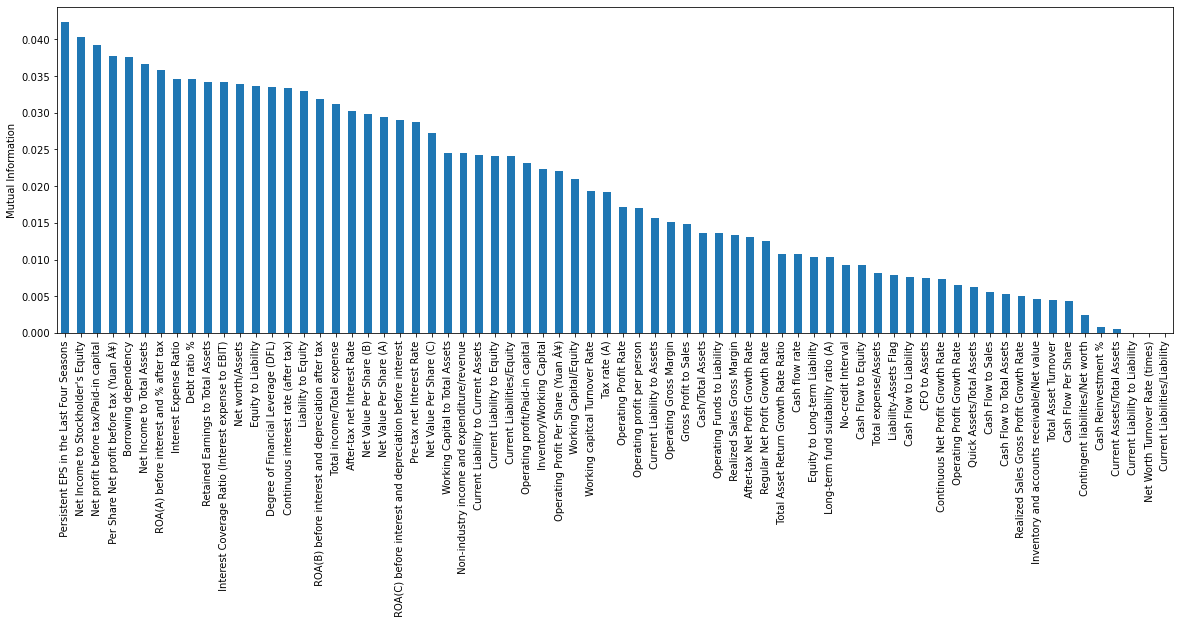

In [11]:
import matplotlib.pyplot as plt

mi = pd.Series(mi)
mi.index = training_features.columns
mi.sort_values(ascending=False).plot.bar(figsize=(20, 6))
plt.ylabel('Mutual Information')

In [12]:
# here we will select the top K(depending on our choice) features
# based on their mutual information value

# select features
sel_ = SelectKBest(mutual_info_classif, k=20).fit(training_features, training_targets)

# display features
training_features.columns[sel_.get_support()]

Index([' ROA(A) before interest and % after tax',
       ' ROA(B) before interest and depreciation after tax',
       ' After-tax net Interest Rate', ' Continuous interest rate (after tax)',
       ' Net Value Per Share (B)', ' Persistent EPS in the Last Four Seasons',
       ' Per Share Net profit before tax (Yuan Â¥)', ' Interest Expense Ratio',
       ' Debt ratio %', ' Net worth/Assets', ' Borrowing dependency',
       ' Net profit before tax/Paid-in capital',
       ' Retained Earnings to Total Assets', ' Total income/Total expense',
       ' Net Income to Total Assets', ' Net Income to Stockholder's Equity',
       ' Liability to Equity', ' Degree of Financial Leverage (DFL)',
       ' Interest Coverage Ratio (Interest expense to EBIT)',
       ' Equity to Liability'],
      dtype='object')

In [13]:
# remove the rest of the features:

training_features = sel_.transform(training_features)
evaluation_features = sel_.transform(evaluation_features)

In [14]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
training_features = sc.fit_transform(training_features)
evaluation_features = sc.transform(evaluation_features)

## Create Estimator and Do Training

In [15]:
#create an estimator
knn_estimator = KNeighborsClassifier()

# specify the parameter grid
parameters = {
    'n_neighbors': range(2, 9)
}

# specify the cross validation
stratified_10_fold_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_SEED)

# create the grid search instance
grid_search_estimator = GridSearchCV(knn_estimator, parameters, scoring='accuracy', cv=stratified_10_fold_cv, return_train_score=False)

# run the grid search
grid_search_estimator.fit(training_features,training_targets)

# print the results of all hyper-parameter combinations
results = pd.DataFrame(grid_search_estimator.cv_results_)
display(results)
    
# print the best parameter setting
print("best score is {} with params {}".format(grid_search_estimator.best_score_, grid_search_estimator.best_params_))

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.001397,0.000488,0.054152,0.007109,2,{'n_neighbors': 2},0.970696,0.965201,0.965201,0.965201,0.959707,0.970642,0.965138,0.968807,0.974312,0.977982,0.968289,0.005040,5
1,0.001696,0.000457,0.068516,0.004893,3,{'n_neighbors': 3},0.967033,0.959707,0.970696,0.963370,0.959707,0.965138,0.968807,0.968807,0.976147,0.976147,0.967556,0.005545,7
2,0.001596,0.000489,0.089212,0.009576,4,{'n_neighbors': 4},0.970696,0.963370,0.968864,0.968864,0.967033,0.965138,0.972477,0.974312,0.974312,0.976147,0.970121,0.004005,1
3,0.001499,0.000497,0.079287,0.006868,5,{'n_neighbors': 5},0.970696,0.963370,0.963370,0.965201,0.963370,0.963303,0.966972,0.970642,0.974312,0.979817,0.968105,0.005375,6
4,0.001498,0.000500,0.078588,0.007106,6,{'n_neighbors': 6},0.970696,0.967033,0.968864,0.965201,0.968864,0.966972,0.970642,0.976147,0.972477,0.974312,0.970121,0.003269,2
5,0.001300,0.000461,0.076293,0.013082,7,{'n_neighbors': 7},0.968864,0.965201,0.963370,0.965201,0.965201,0.966972,0.970642,0.972477,0.976147,0.976147,0.969022,0.004428,4
6,0.001095,0.000290,0.071910,0.005034,8,{'n_neighbors': 8},0.970696,0.965201,0.968864,0.965201,0.968864,0.965138,0.968807,0.974312,0.974312,0.976147,0.969754,0.003854,3


best score is 0.9701213159928758 with params {'n_neighbors': 4}


In [17]:
def confusion_matrix_to_string(cm):
    return f"True operational={cm[0][0]}, True bankrupt={cm[1][1]}, False operational={cm[0][1]}, False bankrupt={cm[1][0]}"

knn_estimator = KNeighborsClassifier(n_neighbors=4)
knn_estimator.fit(training_features, training_targets)

#Use classifier to predict (for training data)
training_predictions = knn_estimator.predict(training_features)
training_accuracy = balanced_accuracy_score(training_targets, training_predictions)
training_confusion_matrix = confusion_matrix(training_targets, training_predictions)
training_confusion_matrix = confusion_matrix_to_string(training_confusion_matrix)
print("Training Accuracy: {}".format(training_accuracy))

#Use classifier to predict (for evaluation data)
evaluation_predictions = knn_estimator.predict(evaluation_features)
evaluation_accuracy = balanced_accuracy_score(evaluation_targets, evaluation_predictions)
evaluation_confusion_matrix = confusion_matrix(evaluation_targets, evaluation_predictions)
evaluation_confusion_matrix = confusion_matrix_to_string(evaluation_confusion_matrix)
print("Evaluation Accuracy: {}".format(evaluation_accuracy))

Training Accuracy: 0.6101324501885688
Evaluation Accuracy: 0.5776515151515151


In [18]:
current_variables = dir()

results_string = ""

for variable in current_variables:
    # Skip environment variables and their container variable
    # Ignore also underscore variables
    if variable in environment_variables or variable == "environment_variables" or variable.startswith("_"):
        continue

    # Get variables value
    variable_value = globals()[variable]

    # If variable is numerical or string, append it to results
    if type(variable_value) is str or type(variable_value) is int or \
        type(variable_value) is float or type(variable_value) is list or \
        type(variable_value) is numpy.float64 or type(variable_value) is dict:
        results_string += f"{variable}: {variable_value}\n"

# Print results to screen
print(results_string)

# Save results to file
with open(OUTPUT_RESULTS, "w") as file:
    file.write(results_string)

HYPER_PARAMETER_CLASS_WEIGHT: balanced
HYPER_PARAMETER_CRITERION: ['gini', 'entropy']
HYPER_PARAMETER_MAX_DEPTH: [10]
HYPER_PARAMETER_MAX_FEATURES: ['auto', 'sqrt', 'log2', None]
HYPER_PARAMETER_OPTIMIZATION_CV: 10
HYPER_PARAMETER_OPTIMIZATION_SCORING: balanced_accuracy
INPUT_EVALUATION_FILE: ../data/preprocessed/difference_preprocessed_evaluation_dataset.csv
INPUT_TRAINING_FILE: ../data/preprocessed/difference_preprocessed_training_dataset.csv
LABELS: ['Operational', 'Bankrupt']
METHOD_NAME: knn
OUTPUT_MODEL: ../data/models/knn_model_09_05_2022-16_03_17.pkl
OUTPUT_RESULTS: ../data/results/knn_model_09_05_2022-16_03_17.txt
PUNISHMENT_FOR_FALSE_BANKRUPT_PREDICTION: 100
RANDOM_SEED: 42
TIMESTAMP: 09_05_2022-16_03_17
evaluation_accuracy: 0.5776515151515151
evaluation_confusion_matrix: True operational=1315, True bankrupt=7, False operational=5, False bankrupt=37
parameters: {'n_neighbors': range(2, 9)}
training_accuracy: 0.6101324501885688
training_confusion_matrix: True operational=5272,